Dataset loaded. Shape: (17918, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010  

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:32:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



[XGBoost Results]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3568
         1.0       1.00      0.81      0.90        16

    accuracy                           1.00      3584
   macro avg       1.00      0.91      0.95      3584
weighted avg       1.00      1.00      1.00      3584



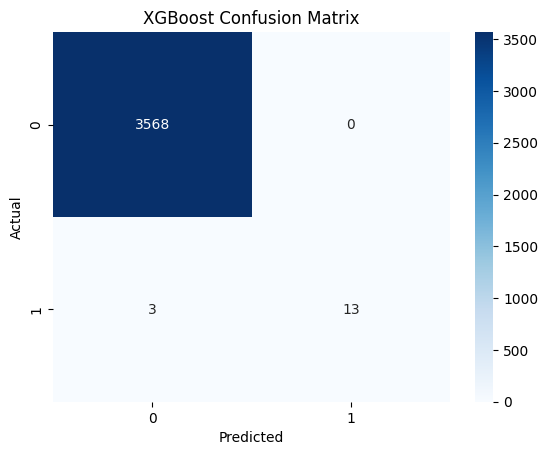

In [2]:
#CREDIT CARD FRAUD DETECTION FULL PIPELINE
# ✅ Uses Isolation Forest, Local Outlier Factor & XGBoost

# Step 1: Install dependencies
!pip install -q xgboost

# Step 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.impute import SimpleImputer # Import SimpleImputer

# Step 3: Load Data
# Updated path to reflect manual upload location in /content/
df = pd.read_csv('/content/creditcard.csv')
print("Dataset loaded. Shape:", df.shape)

# Step 4: Basic Info
print(df.head())
print("Class distribution:\n", df['Class'].value_counts())

# Step 5: Preprocess
# Handle missing values in the target variable before splitting
# Drop rows where 'Class' is NaN
df.dropna(subset=['Class'], inplace=True)
print(f"Dataset shape after dropping rows with missing 'Class': {df.shape}")


X = df.drop('Class', axis=1)
y = df['Class']

# Step 5.1: Handle missing values in features (Imputation)
# Initialize the imputer with a strategy (e.g., mean, median, most_frequent)
imputer = SimpleImputer(strategy='mean')
# Fit and transform the data
X_imputed = imputer.fit_transform(X)
# Convert back to DataFrame if needed (optional but good for readability)
X = pd.DataFrame(X_imputed, columns=X.columns)
print("Missing values in features handled.")


# Step 6: Anomaly Detection Methods (Unsupervised)
clf_if = IsolationForest(contamination=0.0017)  # ~492/284807 frauds
clf_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.0017)

# Use the imputed data X for fitting the models
y_pred_if = clf_if.fit_predict(X)
y_pred_lof = clf_lof.fit_predict(X)

# Convert: -1 = fraud, 1 = normal → 1 = fraud, 0 = normal
y_pred_if = np.where(y_pred_if == -1, 1, 0)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)

print("\n[Isolation Forest Results]")
# Use the cleaned y for evaluation
print(classification_report(y, y_pred_if))
print(confusion_matrix(y, y_pred_if))

print("\n[Local Outlier Factor Results]")
# Use the cleaned y for evaluation
print(classification_report(y, y_pred_lof))
print(confusion_matrix(y, y_pred_lof))

# Step 7: Supervised Learning (XGBoost)
# Ensure that the split uses the cleaned X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
xgb = XGBClassifier(n_estimators=100, scale_pos_weight=100, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("\n[XGBoost Results]")
print(classification_report(y_test, y_pred_xgb))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()